# Оценка грамматической корректности предложений с использованием трансформерных моделей

**Подключение библиотек и загрузка данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments
)
import evaluate

In [2]:
start_path = "data/"
train_path, test_path = "in_domain_train.csv", "in_domain_dev.csv"

train_data = pd.read_csv(start_path + train_path)
test_data = pd.read_csv(start_path + test_path)

train_data.set_index("id",  inplace=True)
test_data.set_index("id",  inplace=True)

print(f"Всего записей:\nв обучающем наборе - {train_data.shape[0]},"
      f"\nв тестовом - {test_data.shape[0]}")

Всего записей:
в обучающем наборе - 7869,
в тестовом - 983


In [3]:
train_data

,sentence,acceptable,error_type,detailed_source
id,,,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010
...,...,...,...,...
7864,Установки не было введено в действие.,0,Semantics,Paducheva2004
7865,"Конечно, против такой системы ценностей решите...",0,Semantics,Paducheva2013
7866,Симптомов болезни не исчезло.,0,Semantics,Paducheva2013


In [4]:
test_data

,sentence,acceptable,error_type,detailed_source
id,,,,
0,Иван вчера не позвонил.,1,0,Paducheva2013
1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets
...,...,...,...,...
978,Мысли отказываются остановиться на всяком пред...,0,Semantics,Paducheva2013
979,"Не должно быть подозрений, что судью привлекаю...",0,Semantics,Paducheva2013
980,"Хорошо, что он купил что-нибудь.",0,Semantics,Rusgram


## EDA

### Описание признаков датасета RuCoLA

- **`sentence`** — предложение на русском языке  
- **`acceptable` (target)** —метка корректности: `1` — предложение грамматически корректное, `0` — некорректное  
- **`error_type`** — тип грамматической ошибки (например, `Syntax`, `Semantics`), либо `0`, если предложение корректное  
- **`detailed_source`** — источник/корпус, из которого взято предложение

***Объединим данные для проведения базового EDA***

In [5]:
full_data = pd.concat([train_data, test_data])

# Проверка на корректность конкатенации
assert full_data.shape == (train_data.shape[0] + test_data.shape[0], train_data.shape[1])

Посмотрим на распределение ошибок

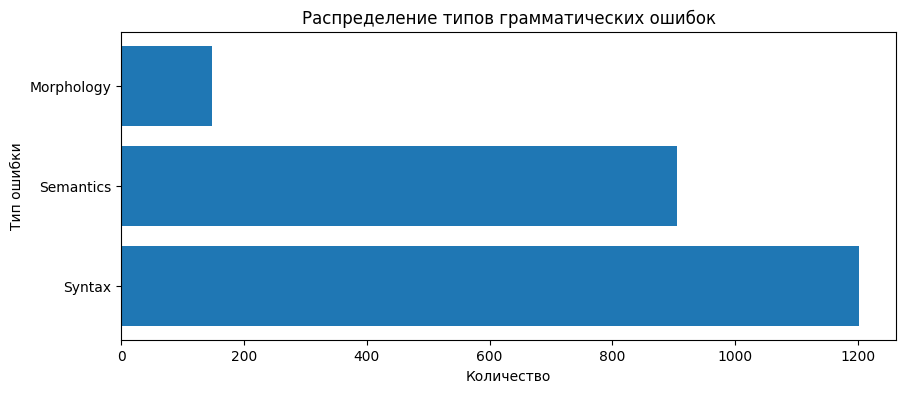

In [6]:
errors = full_data.loc[full_data["error_type"] != "0", "error_type"]

fig = plt.figure(figsize=(10, 4))
plt.barh(errors.unique(), errors.value_counts().to_list())

plt.xlabel("Количество")
plt.ylabel("Тип ошибки")
plt.title("Распределение типов грамматических ошибок")
plt.show()

Выделим источники с наибольшим и наименьшим количеством ошибок

In [7]:
full_data["is_error"] = full_data["acceptable"] == 0

data_by_source = full_data.groupby("detailed_source")
data_by_source.agg({"is_error": "sum"}).sort_values(by="is_error",
                                                      ascending=False)

,is_error
detailed_source,
USE8,686
Seliverstova,359
Testelets,316
Rusgram,252
Paducheva2010,187
Paducheva2013,142
USE7,141
Paducheva2004,113
Lutikova,39


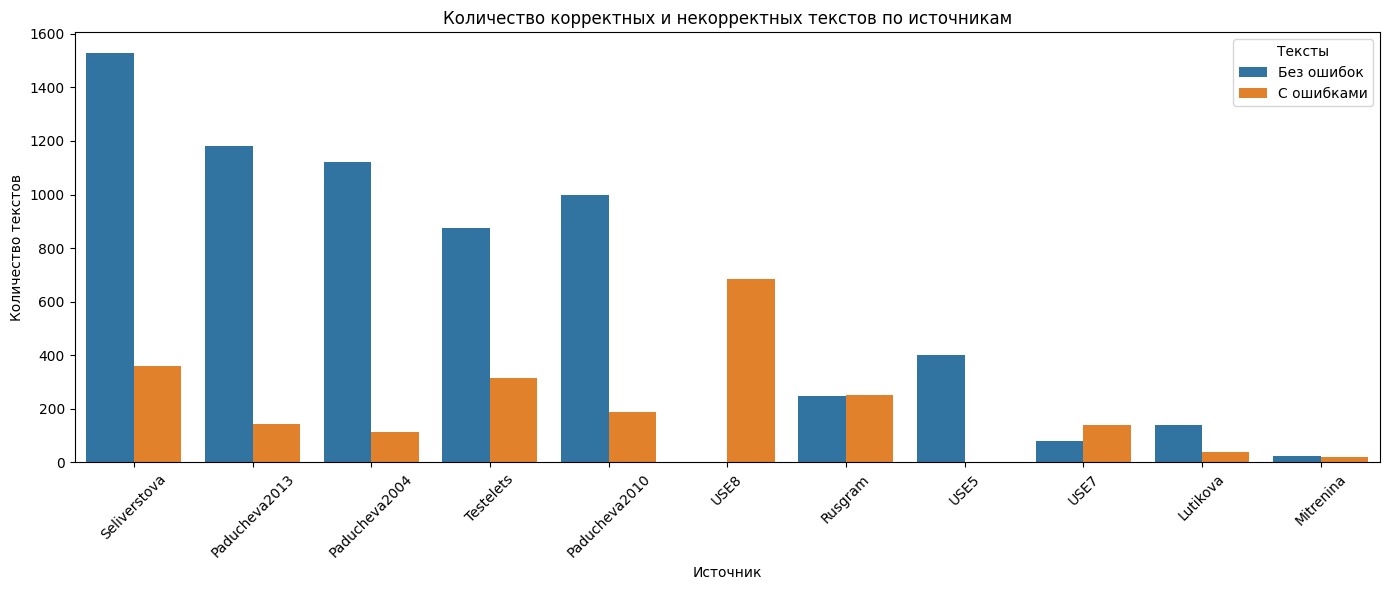

In [8]:
full_data["with_errors"] = full_data["is_error"].replace({
    True: "C ошибками",
    False: "Без ошибок"
})

plt.figure(figsize=(14, 6))
sns.countplot(data=full_data, x="detailed_source", hue="with_errors",
              order=full_data["detailed_source"].value_counts().index)

plt.xlabel("Источник")
plt.ylabel("Количество текстов")
plt.title("Количество корректных и некорректных текстов по источникам")
plt.xticks(rotation=45)
plt.legend(title="Тексты")
plt.tight_layout()
plt.show()

**Анализ таргета**

<Axes: title={'center': 'Распределение по целевому признаку acceptability'}, ylabel='Доля'>

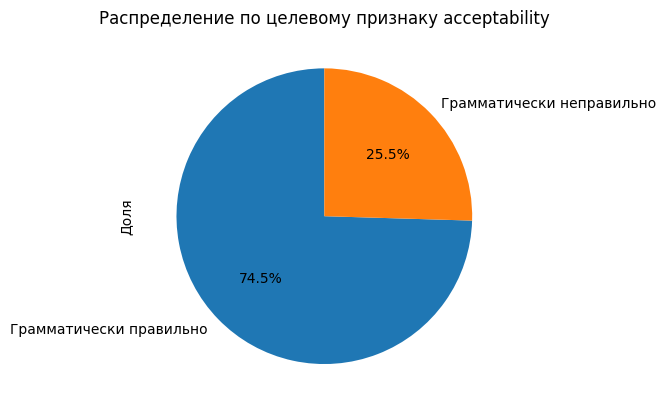

In [9]:
full_data["acceptable"].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, ylabel="Доля",
    labels=["Грамматически правильно", "Грамматически неправильно"],
    title="Распределение по целевому признаку acceptability"
)

#### **Дисбаланс классов в данных есть, но он не критичный**

## Построение модели

***Выделим валидационную выборку***

In [10]:
train_data, val_data = train_test_split(train_data, test_size=0.1,
                                        random_state=42,
                                        stratify=train_data["acceptable"])

print(train_data.shape, val_data.shape)

(7082, 4) (787, 4)


### Токенизация

In [11]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Преобразуем в Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


***Оценим максимальное количество токенов, которое потребуется при токенизации***

In [12]:
full_data["token_len"] = full_data["sentence"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=True))
)

full_data["token_len"].max()

46

In [13]:
train_dataset = train_dataset.map(
    lambda x: tokenizer(x["sentence"], truncation=True,
                        padding="max_length", max_length=64),
    batched=True,
    remove_columns=["sentence"]
)

val_dataset = val_dataset.map(
    lambda x: tokenizer(x["sentence"], truncation=True,
                        padding="max_length", max_length=64),
    batched=True,
    remove_columns=["sentence"]
)

train_dataset, val_dataset

Map:   0%|          | 0/7082 [00:00<?, ? examples/s]

Map:   0%|          | 0/787 [00:00<?, ? examples/s]

(Dataset({
     features: ['acceptable', 'error_type', 'detailed_source', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 7082
 }),
 Dataset({
     features: ['acceptable', 'error_type', 'detailed_source', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 787
 }))

In [14]:
# Удалим лишние поля (всё кроме нужных)
columns_to_keep = ["input_ids", "attention_mask", "acceptable"]

train_dataset = train_dataset.remove_columns(
    [col for col in train_dataset.column_names if col not in columns_to_keep])
val_dataset = val_dataset.remove_columns(
    [col for col in val_dataset.column_names if col not in columns_to_keep])

# Переименуем для модели
train_dataset = train_dataset.rename_column("acceptable", "labels")
val_dataset = val_dataset.rename_column("acceptable", "labels")

# Установим формат torch
train_dataset.set_format("torch")
val_dataset.set_format("torch")

###  Дообучение (Fine-tune) RuBERT на датасете RuCoLA для классификации текста

#### Загрузка модели

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT 

#### Задание метрики

In [16]:
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return f1.compute(predictions=predictions, references=labels)

#### Аргументы обучения

In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

#### Обучение модели BERT (rubert-base-cased) с использованием Hugging Face Trainer

In [18]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "GPU недоступен")

Tesla T4


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [20]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.513280,0.863706
2,0.536000,0.501005,0.871560
3,0.397700,0.600516,0.863745
4,0.239200,0.787239,0.857847
5,0.155100,1.033003,0.862208


TrainOutput(global_step=2215, training_loss=0.3108054847803396, metrics={'train_runtime': 643.9289, 'train_samples_per_second': 54.991, 'train_steps_per_second': 3.44, 'total_flos': 1164595308787200.0, 'train_loss': 0.3108054847803396, 'epoch': 5.0})

**Лучший результат модель показала на третьей эпохе**

#### Оценка качества модели на тестовой выборке

In [21]:
test_dataset = Dataset.from_pandas(test_data)

test_dataset = test_dataset.map(
    lambda x: tokenizer(x["sentence"], truncation=True, padding="max_length", max_length=64),
    batched=True,
    remove_columns=["sentence"]
)

columns_to_keep = ["input_ids", "attention_mask"]
test_dataset = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in columns_to_keep])
test_dataset.set_format("torch")

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

In [22]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=-1)

In [23]:
true_labels = test_data["acceptable"].values
print(classification_report(true_labels, preds, digits=3))

              precision    recall  f1-score   support

           0      0.828     0.288     0.427       250
           1      0.801     0.980     0.882       733

    accuracy                          0.804       983
   macro avg      0.814     0.634     0.654       983
weighted avg      0.808     0.804     0.766       983



**Промежуточные итоги:**

*   Для дообучения модели на 5ти эпохах понадобилось около 10 минут;
*   Наилучшее качество достигается на 2ей эпохе;
*   На валидационной выборке качество довольно высокое (F1-score = 0.87);
*   На тестовой выборке качество также хорошее, однако проседает recall для минорного класса <br>грамматически неправильных предложений, то есть модель склонна их пропускать





###Генеративный подход к классификации предложений с помощью RuGPT-3

#### Загрузка модели и токенизатора RuGPT3 (large)

In [24]:
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### Вспомогательные функции

In [25]:
generative_results = []

# Функция генерации ответа
def generate(prompt, expected_label, style_name, max_new_tokens=5):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,   # максимальное число токенов в ответе
        do_sample=False,                 # без случайной выборки, только самый вероятный токен
        temperature=0.0,                 # строгое поведение, нет случайности, никакой креативности в ответе
        top_k=1                          # выбирать только из 1 наиболее вероятного токена
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response_raw = decoded[len(prompt):].strip()
    response_clean = response_raw.split("\n")[0].strip()

    expected_text = "корректно" if expected_label == 1 else "некорректно"

    print("\n=== Prompt ===\n" + prompt)
    print(f"\n=== Ожидаемый ответ: {expected_text}")
    print(f"=== Предсказание: {response_clean or '(пусто)'}")

    generative_results.append({
        "sentence": prompt.split("Предложение: ")[-1].split("\n")[0],
        "expected": expected_text,
        "predicted": response_clean,
        "style": style_name
    })

In [26]:
# Стиль 1: Инструкция + предложение
def make_prompt_style_1(sentence):
    return f"Оцени, является ли предложение грамматически корректным/некорректным.\nПредложение: {sentence}"

# Стиль 2: Список примеров (короткий стиль)
def make_prompt_style_2(examples, sentence):
    lines = "\n".join([f"{ex} — {'корректно' if label else 'некорректно'}" for ex, label in examples])
    return f"Оцени грамматическую корректность предложений:\n{lines}\n{sentence} —"

# Стиль 3: Словесная инструкция с префиксом
def make_prompt_style_3(examples, sentence):
    head = "Определи корректность каждого предложения, отвечай 'корректно' или 'некорректно'."
    lines = "\n".join([f"Предложение: {ex}\nОтвет: {'корректно' if label else 'некорректно'}" for ex, label in examples])
    return f"{head}\n{lines}\nПредложение: {sentence}"

#### Выборка примеров

In [27]:
# Выберем случайным образом 4 предложения для теста и 4 для few-shot

samples = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_sentences = [
    (row["sentence"], row["acceptable"])
    for _, row in samples.iloc[:4].iterrows()
]

correct_examples = test_data[test_data["acceptable"] == 1].sample(n=2, random_state=42)
incorrect_examples = test_data[test_data["acceptable"] == 0].sample(n=2, random_state=42)

examples_df = pd.concat([correct_examples, incorrect_examples]).sample(frac=1, random_state=42).reset_index(drop=True)

examples_fewshot = [
    (row["sentence"], row["acceptable"])
    for _, row in examples_df.iterrows()
]

In [28]:
# === ZERO-SHOT (Style 1) ===
print("\n===== ZERO-SHOT (Style 1) =====")
for s, label in test_sentences:
    prompt = make_prompt_style_1(s)
    generate(prompt, label, style_name="zero-shot")

# === ONE-SHOT (Style 2) ===
print("\n===== ONE-SHOT (Style 2) =====")
for s, label in test_sentences:
    prompt = make_prompt_style_2(examples_fewshot[:1], s)
    generate(prompt, label, style_name="one-shot")

# === TWO-SHOT (Style 2) ===
print("\n===== TWO-SHOT (Style 2) =====")
for s, label in test_sentences:
    prompt = make_prompt_style_2(examples_fewshot[:2], s)
    generate(prompt, label, style_name="two-shot")

# === FOUR-SHOT (Style 2) ===
print("\n===== FOUR-SHOT (Style 2) =====")
for s, label in test_sentences:
    prompt = make_prompt_style_2(examples_fewshot[:4], s)
    generate(prompt, label, style_name="four-shot (style 2)")

# === FOUR-SHOT (Style 3) ===
print("\n===== FOUR-SHOT (Style 3) =====")
for s, label in test_sentences:
    prompt = make_prompt_style_3(examples_fewshot[:4], s)
    generate(prompt, label, style_name="four-shot (style 3)")


===== ZERO-SHOT (Style 1) =====

=== Prompt ===
Оцени, является ли предложение грамматически корректным/некорректным.
Предложение: Том и Гек разговаривают.

=== Ожидаемый ответ: корректно
=== Предсказание: Гек: Том

=== Prompt ===
Оцени, является ли предложение грамматически корректным/некорректным.
Предложение: Я воздержался от каких бы то ни было комментариев.

=== Ожидаемый ответ: корректно
=== Предсказание: Предложение: Я

=== Prompt ===
Оцени, является ли предложение грамматически корректным/некорректным.
Предложение: В доме был большой круглый стой, все любили собираться и разговаривать в гостиной у него.

=== Ожидаемый ответ: некорректно
=== Предсказание: Оцени, является

=== Prompt ===
Оцени, является ли предложение грамматически корректным/некорректным.
Предложение: Так я и пойду!

=== Ожидаемый ответ: корректно
=== Предсказание: Оцени, является

===== ONE-SHOT (Style 2) =====

=== Prompt ===
Оцени грамматическую корректность предложений:
В нашем лесу есть озеро. — корректно


In [29]:
generative_results_df = pd.DataFrame(generative_results)
generative_results_df

,sentence,expected,predicted,style
0,Том и Гек разговаривают.,корректно,Гек: Том,zero-shot
1,Я воздержался от каких бы то ни было комментар...,корректно,Предложение: Я,zero-shot
2,"В доме был большой круглый стой, все любили со...",некорректно,"Оцени, является",zero-shot
3,Так я и пойду!,корректно,"Оцени, является",zero-shot
4,Оцени грамматическую корректность предложений:,корректно,корректно,one-shot
5,Оцени грамматическую корректность предложений:,корректно,корректно,one-shot
6,Оцени грамматическую корректность предложений:,некорректно,корректно,one-shot
7,Оцени грамматическую корректность предложений:,корректно,корректно,one-shot
8,Оцени грамматическую корректность предложений:,корректно,корректно,two-shot
9,Оцени грамматическую корректность предложений:,корректно,некорректно,two-shot


Так как генеративная модель `RuGPT3` применялась в режиме **zero/few-shot** и тестировалась на небольшой подвыборке из 4 предложений, мы не можем сравнивать численные метрики напрямую с дообученной моделью `RuBERT`, обучавшейся на всей тренировочной выборке. Однако при ручной проверке видно, что `RuGPT3` начинает выдавать правильные предсказания уже при 1–2 примерах (**few-shot**), а при 4 примерах качество стабилизируется.

## Вывод

В ходе работы проведён **EDA**, **дообучение** и **тестирование** модели `RuBERT`, а также эксперименты с `RuGPT3` в **zero-/few-shot** режиме с различными затравками. Принцип дообучения оказался достаточно эффективным — модель достигла `F1-score ≈ 0.87` на валидации. Анализ показал, что основной недостаток — в **низком `recall`** для некорректных предложений. Однако, итоговый **`weighted F1-score`** на тесте составил **`~0.77`**, что подтверждает устойчивость модели на реальных данных. Для улучшения качества можно использовать балансировку классов или модифицировать функцию потерь. Модель `RuGPT3` начинает выдавать разумные ответы **уже при 1–2 примерах в затравке**.